# 航线低价预测模型
* 数据来源：./datasets/bs_feature_process_csv等经过数据预处理的五条航线训练样本
* 代码内容：构建时间序列，训练LSTM模型，并进行模型评估和绘制预测曲线

In [8]:
import pandas as pd
import numpy as np
from pandas import DataFrame
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
import datetime
import keras
import keras.preprocessing as preprocessing
from keras.models import Sequential
from keras.layers import LSTM,Merge,Activation,Dense,TimeDistributed,GRU
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import pyplot

## 1. 从CSV导入数据

In [9]:
df_bs = pd.read_csv('../datasets/airroute_feature_processed-Copy1.csv',sep = ',',encoding = 'utf-8')

In [10]:
df_bs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32936 entries, 0 to 32935
Data columns (total 75 columns):
dep_date                              32936 non-null object
search_date                           32936 non-null object
pre_day                               32936 non-null int64
search_num                            32936 non-null int64
dep_city_search_num                   32936 non-null int64
arr_city_search_num                   32936 non-null int64
minprice                              32936 non-null float64
dep_month_of_year                     32936 non-null int64
dep_day_of_week                       32936 non-null int64
dep_week_of_year                      32936 non-null int64
search_month_of_year                  32936 non-null int64
search_day_of_week                    32936 non-null int64
search_week_of_year                   32936 non-null int64
history_1d_by_dep_price               32936 non-null float64
history_2d_by_dep_price               32936 non-null float6

In [11]:
df_bs.describe().T

,count,mean,std,min,25%,50%,75%,max
pre_day,32936.0,2.250000e+01,1.327612e+01,0.000000,1.100000e+01,2.250000e+01,3.400000e+01,4.500000e+01
search_num,32936.0,7.474540e+06,3.773076e+07,225.000000,1.599725e+05,5.015110e+05,2.053267e+06,8.281816e+08
dep_city_search_num,32936.0,3.901468e+07,1.281240e+08,20244.000000,2.248055e+06,6.738234e+06,2.342726e+07,2.876131e+09
arr_city_search_num,32936.0,3.947758e+07,1.228433e+08,33404.000000,2.711478e+06,7.722187e+06,2.460655e+07,2.390418e+09
minprice,32936.0,4.322941e+02,6.990631e+01,356.000000,3.700000e+02,4.200000e+02,4.700000e+02,1.180000e+03
dep_month_of_year,32936.0,6.594972e+00,3.445668e+00,1.000000,4.000000e+00,7.000000e+00,1.000000e+01,1.200000e+01
dep_day_of_week,32936.0,2.998603e+00,1.997584e+00,0.000000,1.000000e+00,3.000000e+00,5.000000e+00,6.000000e+00
dep_week_of_year,32936.0,2.677793e+01,1.497794e+01,1.000000,1.400000e+01,2.700000e+01,4.000000e+01,5.200000e+01
search_month_of_year,32936.0,6.615011e+00,3.420512e+00,1.000000,4.000000e+00,7.000000e+00,1.000000e+01,1.200000e+01
search_day_of_week,32936.0,2.999727e+00,2.000068e+00,0.000000,1.000000e+00,3.000000e+00,5.000000e+00,6.000000e+00


In [12]:
df_bs.columns

Index(['dep_date', 'search_date', 'pre_day', 'search_num',
       'dep_city_search_num', 'arr_city_search_num', 'minprice',
       'dep_month_of_year', 'dep_day_of_week', 'dep_week_of_year',
       'search_month_of_year', 'search_day_of_week', 'search_week_of_year',
       'history_1d_by_dep_price', 'history_2d_by_dep_price',
       'history_3d_by_dep_price', 'history_4d_by_dep_price',
       'history_5d_by_dep_price', 'history_6d_by_dep_price',
       'history_7d_by_dep_price', 'history_8d_by_dep_price',
       'history_9d_by_dep_price', 'history_10d_by_dep_price',
       'history_11d_by_dep_price', 'history_12d_by_dep_price',
       'history_13d_by_dep_price', 'history_14d_by_dep_price',
       'history_15d_by_dep_price', 'history_1d_by_preday_price',
       'history_2d_by_preday_price', 'history_3d_by_preday_price',
       'history_4d_by_preday_price', 'history_5d_by_preday_price',
       'history_6d_by_preday_price', 'history_7d_by_preday_price',
       'history_8d_by_preday_price'

In [13]:
df_bs.head(46)

,dep_date,search_date,pre_day,search_num,dep_city_search_num,arr_city_search_num,minprice,dep_month_of_year,dep_day_of_week,dep_week_of_year,...,history_1w_by_preday_decline_count,history_1w_by_preday_rise_count,history_2w_by_preday_mean,history_2w_by_preday_var,history_2w_by_preday_min,history_2w_by_preday_max,history_2w_by_preday_median,history_2w_by_preday_mode,history_2w_by_preday_decline_count,history_2w_by_preday_rise_count
0,2016-03-16,2016-01-31,45,13275,349929,362201,420.0,3,2,11,...,2,4,369.133333,196.980952,356.0,390.0,362.0,360.0,4,8
1,2016-03-16,2016-02-01,44,20655,535167,571374,356.0,3,2,11,...,2,2,369.400000,207.257143,357.0,400.0,360.0,360.0,7,3
2,2016-03-16,2016-02-02,43,116580,1064764,1186034,356.0,3,2,11,...,3,3,366.066667,284.352381,356.0,420.0,360.0,360.0,7,5
3,2016-03-16,2016-02-03,42,19109,813345,1098622,362.0,3,2,11,...,1,2,363.666667,63.666667,360.0,390.0,360.0,360.0,5,4
4,2016-03-16,2016-02-04,41,76300,1382640,1743560,360.0,3,2,11,...,4,2,372.466667,705.838095,360.0,450.0,361.0,360.0,7,5
5,2016-03-16,2016-02-05,40,47520,854744,1000296,362.0,3,2,11,...,4,2,372.800000,706.314286,356.0,450.0,361.0,360.0,8,5
6,2016-03-16,2016-02-06,39,31488,898688,1204864,361.0,3,2,11,...,2,3,367.666667,275.952381,360.0,420.0,362.0,360.0,3,4
7,2016-03-16,2016-02-07,38,23760,446688,610434,430.0,3,2,11,...,2,2,369.266667,262.495238,360.0,420.0,362.0,360.0,5,6
8,2016-03-16,2016-02-08,37,60900,1169280,1163120,362.0,3,2,11,...,3,1,372.466667,660.409524,356.0,450.0,362.0,362.0,6,5
9,2016-03-16,2016-02-09,36,42375,1486854,1316789,362.0,3,2,11,...,3,2,373.200000,392.885714,360.0,430.0,362.0,360.0,7,5


## 2. 数据处理

### 2.1 将dep_date和search_date合并为dep_search_date，指定为索引

In [14]:
# dep_search_date = df_bs[['dep_date','search_date']].apply(lambda x : str(x[0])[:10] + ',' + str(x[1])[:10], axis = 1)
# df_bs.insert(0, 'dep_search_date', dep_search_date)
del df_bs['search_date']
del df_bs['dep_date']
# df_bs.set_index('dep_search_date',inplace=True)

### 2.2 minprice调整到最后一列

In [15]:
minprice = df_bs['minprice']
df_bs.drop(labels=['minprice'], axis=1,inplace = True)
df_bs.insert(df_bs.shape[1], 'minprice', minprice)

### 2.3 归一化处理

In [16]:
df = df_bs.copy()
scaler_bs = MinMaxScaler(feature_range=(0,1))
df.iloc[:,:] = scaler_bs.fit_transform(df.iloc[:,:])

In [17]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
pre_day,32936.0,0.500000,0.295025,0.0,0.244444,0.500000,0.755556,1.0
search_num,32936.0,0.009025,0.045559,0.0,0.000193,0.000605,0.002479,1.0
dep_city_search_num,32936.0,0.013558,0.044548,0.0,0.000775,0.002336,0.008138,1.0
arr_city_search_num,32936.0,0.016501,0.051391,0.0,0.001120,0.003217,0.010280,1.0
dep_month_of_year,32936.0,0.508634,0.313243,0.0,0.272727,0.545455,0.818182,1.0
dep_day_of_week,32936.0,0.499767,0.332931,0.0,0.166667,0.500000,0.833333,1.0
dep_week_of_year,32936.0,0.505450,0.293685,0.0,0.254902,0.509804,0.764706,1.0
search_month_of_year,32936.0,0.510456,0.310956,0.0,0.272727,0.545455,0.818182,1.0
search_day_of_week,32936.0,0.499954,0.333345,0.0,0.166667,0.500000,0.833333,1.0
search_week_of_year,32936.0,0.506503,0.292343,0.0,0.254902,0.509804,0.764706,1.0


## 3. 建立LSTM模型

### 3.1 划分训练集、测试集和验证集

In [18]:
i = 46 # 时间步长
values = df.values
n_train_hour = int(values.shape[0]/i * 0.8)* i
train = values[:n_train_hour,:]
test  = values[n_train_hour:,:]
# 提取特征和标记
train_X_bs,train_y_bs = train[:,:-1],train[:,-1:]
test_X_bs, test_y_bs  = test[:,:-1],test[:,-1:]
# 变换输入数据维度为[样本,时间步长,特征]
train_X_bs = train_X_bs.reshape((int(train_X_bs.shape[0]/i),i,train_X_bs.shape[1]))
train_y_bs = train_y_bs.reshape((int(train_y_bs.shape[0]/i),i,train_y_bs.shape[1]))
test_X_bs  = test_X_bs.reshape((int(test_X_bs.shape[0]/i),i,test_X_bs.shape[1]))
test_y_bs  = test_y_bs.reshape((int(test_y_bs.shape[0]/i),i,test_y_bs.shape[1]))
print(train_X_bs.shape,train_y_bs.shape,test_X_bs.shape,test_y_bs.shape)

(572, 46, 72) (572, 46, 1) (144, 46, 72) (144, 46, 1)


### 3.2 LSTM模型

In [19]:
# 设计网络
adam = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-09)
rel = keras.regularizers.l1(0.0001)
model_1 = Sequential()
# 隐藏层大小
hidden_size = 144
# 输入层
model_1.add(LSTM(hidden_size,input_shape=(train_X_bs.shape[1], train_X_bs.shape[2]), activation='relu', dropout=0.2, return_sequences=True))
# 第二层
model_1.add(LSTM(hidden_size, input_dim=hidden_size, activation='relu', dropout=0.2, return_sequences=True))
# 第三层
# 输出层
model_1.add(TimeDistributed(Dense(1,kernel_regularizer = rel)))
# 定义损失函数和最优化函数
model_1.compile(loss='mae',optimizer=adam)
# 训练网络
model_1.fit(train_X_bs, train_y_bs, epochs=100, batch_size=4, validation_data=(test_X_bs, test_y_bs), verbose=2, shuffle=False)

/notebooks/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:10: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
/notebooks/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:10: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(144, activation="relu", dropout=0.2, return_sequences=True, input_shape=(None, 144...)`


Train on 572 samples, validate on 144 samples
Epoch 1/100
 - 9s - loss: 0.0581 - val_loss: 0.0418
Epoch 2/100
 - 9s - loss: 0.0481 - val_loss: 0.0397
Epoch 3/100
 - 8s - loss: 0.0461 - val_loss: 0.0378
Epoch 4/100
 - 8s - loss: 0.0434 - val_loss: 0.0361
Epoch 5/100
 - 8s - loss: 0.0423 - val_loss: 0.0376
Epoch 6/100
 - 8s - loss: 0.0418 - val_loss: 0.0367
Epoch 7/100
 - 9s - loss: 0.0408 - val_loss: 0.0371
Epoch 8/100
 - 8s - loss: 0.0391 - val_loss: 0.0363
Epoch 9/100
 - 8s - loss: 0.0393 - val_loss: 0.0351
Epoch 10/100
 - 9s - loss: 0.0380 - val_loss: 0.0343
Epoch 11/100
 - 8s - loss: 0.0378 - val_loss: 0.0339
Epoch 12/100
 - 8s - loss: 0.0373 - val_loss: 0.0345
Epoch 13/100
 - 8s - loss: 0.0373 - val_loss: 0.0334
Epoch 14/100
 - 8s - loss: 0.0365 - val_loss: 0.0340
Epoch 15/100
 - 8s - loss: 0.0365 - val_loss: 0.0342
Epoch 16/100
 - 8s - loss: 0.0357 - val_loss: 0.0323
Epoch 17/100
 - 8s - loss: 0.0351 - val_loss: 0.0316
Epoch 18/100
 - 8s - loss: 0.0356 - val_loss: 0.0313
Epoch 19/

### 3.3 模型评估

In [20]:
# 预测并转换为二维数据
yhat_bs = model_1.predict(test_X_bs)
yhat_bs.resize(yhat_bs.shape[0]*yhat_bs.shape[1],1)
# 归一化处理后，结果要转回原值进行误差计算
# 预测值转换
minimum = df_bs['minprice'].min()
differ = df_bs['minprice'].max()-minimum
pred = yhat_bs*differ+minimum
# 真实值
true = df_bs.iloc[n_train_hour:,-1].values
# 计算均方根误差和平均绝对百分误差
rmse = np.sqrt(mean_squared_error(true, pred))
mape = np.mean(np.abs(true-pred)/true)
print('Test RMSE: %.3f' % rmse)
print('Test MAPE: %.3f' % mape)

Test RMSE: 32.524
Test MAPE: 0.134


### 3.4 绘制曲线

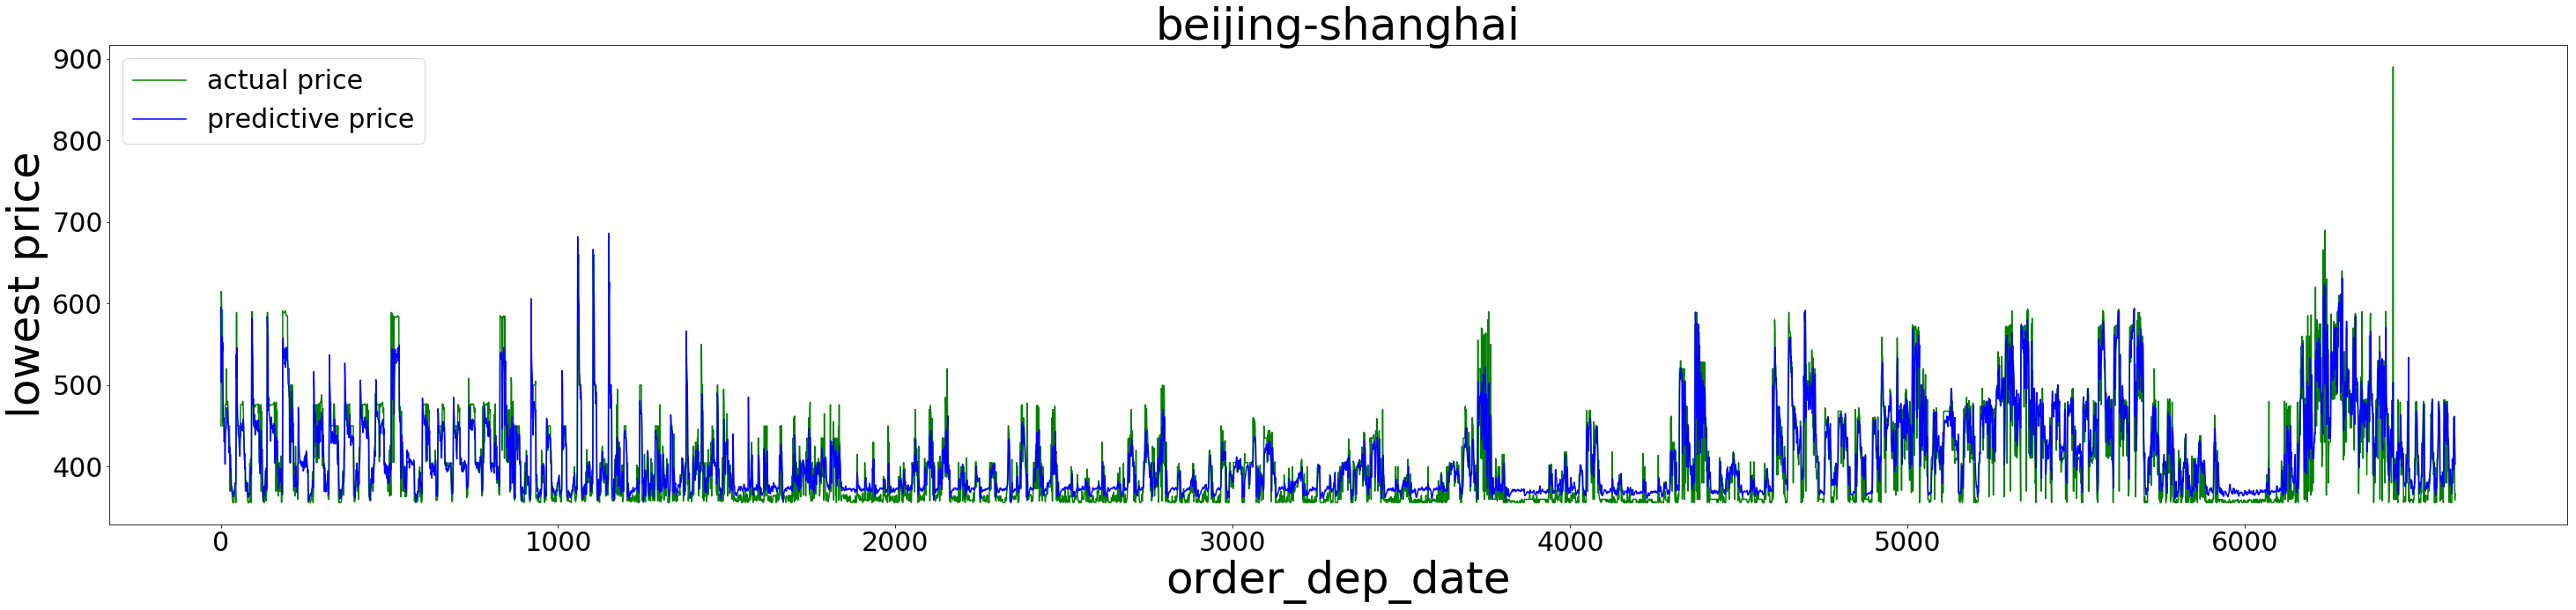

In [21]:
fig = plt.figure(figsize=(50,10))
ax = fig.add_subplot(111)
# ax.set_xticks(range(len(labels)))
# labels = ['2017-10-16,2017-11-16','2017-10-17,2017-11-16','2017-10-18,2017-11-16','2017-10-19,2017-11-16','2017-10-20,2017-11-16','2017-10-21,2017-11-16','2017-10-22,2017-11-16']
# ax.set_xticklabels(labels)
xaxis = ax.yaxis        
for line in xaxis.get_ticklabels():
    line.set_fontsize(30)          # 设置字体大小;
yaxis = ax.xaxis        
for line in yaxis.get_ticklabels():
    line.set_fontsize(30)          # 设置字体大小;
# plot baseline and predictions
plt.plot(true,'g',label="actual price")
plt.plot(pred,'b',label="predictive price")
plt.title('beijing-shanghai',fontsize=50)
plt.xlabel('order_dep_date',fontsize=50)
plt.ylabel('lowest price',fontsize=50)
plt.legend(fontsize=30)
plt.show()